In [1]:
import pandas as pd

# Load PRIS trend capacity data
df_trend = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\pris\trend_reports\power_capacity.csv")
# Rename and filter for Net Capacity (MW)
# Assuming the capacity column is named 'NetCapacityMW' or similar; adjust if needed.
df_trend = df_trend.rename(columns={
    'Net Capacity (MW)': 'Capacity_MW',
    'Year': 'Year',
    'Country or area': 'Country'
})

# Pivot to get 2018 and 2023 capacities per country
df_cap = df_trend[df_trend['Year'].isin([2018, 2023])]
df_cap = df_cap.pivot(index='Country', columns='Year', values='Capacity_MW').dropna()
# Compute CAGR over 5 years
df_cap['CAGR_Capacity'] = (df_cap[2023] / df_cap[2018]) ** (1/5) - 1

# Load generation share data with historic percentages
df_gen = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\nuclear_generation_by_country.csv")
# Clean column names
df_gen.columns = df_gen.columns.str.strip()
# Identify share columns for 2018 and 2023
share_cols = [c for c in df_gen.columns if 'Nuclear share of electricity' in c]
col2018 = [c for c in share_cols if '2018' in c][0]
col2023 = [c for c in share_cols if '2023' in c][0]

df_share = df_gen[['Country', col2018, col2023]].dropna()
df_share = df_share.set_index('Country')
df_share['Delta_Share'] = df_share[col2023] - df_share[col2018]

# Merge capacity CAGR and share delta
df_score = df_cap[['CAGR_Capacity']].join(df_share['Delta_Share'], how='inner')
df_score = df_score.sort_values('CAGR_Capacity', ascending=False).head(10)

# Prepare for display
df_score_display = df_score.reset_index().rename(columns={
    'CAGR_Capacity': '5yr Capacity CAGR',
    'Delta_Share': 'Change in Nuclear Share (2018→2023)'
})

import ace_tools as tools; tools.display_dataframe_to_user(name="Top 10 Fastest-Growing Nuclear Markets", dataframe=df_score_display)


KeyError: 'Country'

In [2]:
import pandas as pd
from ace_tools import display_dataframe_to_user

# Load PRIS OData CSVs
df_op = pd.read_csv("data/pris_csv/OperationalReactorsByCountry.csv")
df_uc = pd.read_csv("C:\Users\Armstrong\nuclear\data\pris\under_construction.csv")

# Dynamically identify country and capacity columns
country_col_op = next(c for c in df_op.columns if 'country' in c.lower())
cap_col_op     = next(c for c in df_op.columns if 'capacity' in c.lower())
country_col_uc = next(c for c in df_uc.columns if 'country' in c.lower())
cap_col_uc     = next(c for c in df_uc.columns if 'capacity' in c.lower())

# Rename for consistency
df_op = df_op.rename(columns={country_col_op: 'Country', cap_col_op: 'OperationalCapacity_MW'})
df_uc = df_uc.rename(columns={country_col_uc: 'Country', cap_col_uc: 'UnderConstructionCapacity_MW'})

# Merge datasets
df_growth = pd.merge(
    df_op[['Country','OperationalCapacity_MW']],
    df_uc[['Country','UnderConstructionCapacity_MW']],
    on='Country',
    how='left'
).fillna(0)

# Compute pipeline metrics
df_growth['PipelineAbs_MW'] = df_growth['UnderConstructionCapacity_MW']
df_growth['PipelinePct'] = df_growth['UnderConstructionCapacity_MW'] / df_growth['OperationalCapacity_MW'] * 100

# Top 10 by pipeline percentage
df_top_pct = df_growth.sort_values('PipelinePct', ascending=False).head(10)
# Top 10 by absolute pipeline MW
df_top_abs = df_growth.sort_values('PipelineAbs_MW', ascending=False).head(10)

# Display the dataframes to the user
display_dataframe_to_user(
    name="Top 10 Markets by Pipeline % Growth",
    dataframe=df_top_pct.reset_index(drop=True)
)
display_dataframe_to_user(
    name="Top 10 Markets by Pipeline Capacity (MW)",
    dataframe=df_top_abs.reset_index(drop=True)
)


,Year,Total Net Electrical Capacity\n[GW],Number of Operated Reactors,Year-end Total Net Electrical Capacity\n[GW],Year-end Operational Reactors
0,2004,366.05,443,364.54,437
1,2005,368.98,442,368.04,440
2,2006,371.73,442,369.49,434
3,2007,371.62,438,369.48,436
4,2008,369.74,436,368.27,434
5,2009,369.91,436,367.41,433
6,2010,372.12,438,370.93,436
7,2011,375.91,442,350.66,414
8,2012,356.32,419,350.94,412
9,2013,355.32,416,349.47,409


In [11]:

import streamlit as st
import pandas as pd

# --- 1) Load data from your exact paths
df_op = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\wn_all_countries_reactors.csv")
df_uc = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\pris\under_construction.csv")

# --- 2) Aggregate existing (operational) capacity by country
# Use the 'Capacity (MWe)' column since 'Net Capacity (MWe)' is NaN
df_op_agg = (
    df_op
    .groupby("Country", as_index=False)["Capacity (MWe)"]
    .sum()
    .rename(columns={"Capacity (MWe)": "OperationalCapacity_MW"})
)

# --- 3) Prepare under-construction summary
df_uc = df_uc.rename(columns={
    "Total Net Electrical Capacity [MW]": "UnderConstructionCapacity_MW"
})
# Clean country strings (if needed)
df_uc["Country"] = df_uc["Country"].str.strip()

# --- 4) Merge and compute pipeline metrics
df = (
    df_op_agg
    .merge(df_uc[["Country", "UnderConstructionCapacity_MW"]],
           on="Country", how="left")
    .fillna(0)
)
df["PipelineAbs_MW"] = df["UnderConstructionCapacity_MW"]
df["PipelinePct"] = (df["UnderConstructionCapacity_MW"] 
                     / df["OperationalCapacity_MW"]) * 100

# --- 5) Select Top 10 by PipelinePct
top10_pct = df.sort_values("PipelinePct", ascending=False).head(10).copy()
top10_pct["PipelinePct"] = top10_pct["PipelinePct"].round(1)

# --- 6) Display in Streamlit
st.subheader("Top 10 Countries by Under-Construction Capacity (% of Current Fleet)")
st.dataframe(
    top10_pct.set_index("Country")[
        ["OperationalCapacity_MW", "UnderConstructionCapacity_MW", "PipelinePct"]
    ]
)



2025-05-27 17:13:33.869 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:13:34.139 
  command:

    streamlit run C:\Users\Armstrong\AppData\Local\anaconda3\envs\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-27 17:13:34.140 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:13:34.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:13:34.266 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [15]:
import pandas as pd

# Load datasets
df_op = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\wn_all_countries_reactors.csv")
df_uc = pd.read_csv(r"C:\Users\Armstrong\nuclear\data\pris\under_construction.csv")

# Aggregate current capacity
df_op_agg = (
    df_op.groupby("Country", as_index=False)["Capacity (MWe)"]
    .sum()
    .rename(columns={"Capacity (MWe)": "OperationalCapacity_MW"})
)

# Prepare under-construction
df_uc = df_uc.rename(columns={"Total Net Electrical Capacity [MW]": "UnderConstructionCapacity_MW"})
df_uc["Country"] = df_uc["Country"].str.strip()

# 1) Show all under-construction entries (non-zero)
print("Under-Construction > 0:")
print(df_uc[df_uc["UnderConstructionCapacity_MW"] > 0])

# 2) Check which countries align for the merge
op_countries = set(df_op_agg["Country"])
uc_countries = set(df_uc["Country"])
print("\nCountries only in operational data:", op_countries - uc_countries)
print("\nCountries only in under-construction data:", uc_countries - op_countries)

# 3) Inspect a few mismatches manually
mismatches = list(uc_countries - op_countries)[:10]
print("\nSample UC-only country names:", mismatches)


Under-Construction > 0:
                      Country  UnderConstructionCapacity_MW  \
0              UNITED KINGDOM                          3260   
1                     UKRAINE                          2070   
2                     TÜRKIYE                          4456   
3                    SLOVAKIA                           440   
4                      RUSSIA                          3850   
5                    PAKISTAN                          1117   
6          KOREA, REPUBLIC OF                          2680   
7                       JAPAN                          2653   
8   IRAN, ISLAMIC REPUBLIC OF                           974   
9                       INDIA                          4768   
10                      EGYPT                          4400   
11                      CHINA                         29638   
12                     BRAZIL                          1340   
13                 BANGLADESH                          2160   
14                  ARGENTINA  

In [18]:
import pandas as pd
import unidecode

# Helper to normalize strings
def norm(name):
    return unidecode.unidecode(name).lower().strip()

# Apply normalization
df_op_agg['Country_key'] = df_op_agg['Country'].apply(norm)
df_uc['Country_key']   = df_uc['Country'].apply(norm)

# Define manual mappings for known synonyms
mapping = {
    'united kingdom':            'united kingdom',
    'uk':                        'united kingdom',
    'korea, republic of':       'south korea',
    'turkiye':                  'turkey',
    'iran, islamic republic of':'iran',
    'united states of america': 'usa',
    'us':                        'usa',
    # add more as needed...
}

# Map keys
df_op_agg['Country_key'] = df_op_agg['Country_key'].replace(mapping)
df_uc['Country_key']     = df_uc['Country_key'].replace(mapping)

# Now merge on Country_key
df = (
    df_op_agg.drop(columns=['Country'])
    .merge(
        df_uc[['Country_key','UnderConstructionCapacity_MW']],
        on='Country_key', how='left'
    )
    .fillna(0)
)
# Bring back the display Country name
df['Country'] = df_op_agg['Country']

# Compute pipeline percent
df['PipelinePct'] = df['UnderConstructionCapacity_MW'] / df['OperationalCapacity_MW'] * 100

# Top 10
top10 = df.sort_values('PipelinePct', ascending=False).head(10)


In [20]:
top10

,OperationalCapacity_MW,Country_key,UnderConstructionCapacity_MW,Country,PipelinePct
10,4400.0,egypt,4400.0,Egypt,100.000000
2,2160.0,bangladesh,2160.0,Bangladesh,100.000000
34,4456.0,turkey,4456.0,Turkey,100.000000
16,1889.0,iran,974.0,Iran,51.561673
5,3224.0,brazil,1340.0,Brazil,41.563275
15,12823.0,india,4768.0,India,37.183186
37,9143.0,united kingdom,3260.0,United Kingdom,35.655693
8,90049.0,china,29638.0,China,32.913192
23,4362.0,pakistan,1117.0,Pakistan,25.607519
26,2742.0,slovakia,440.0,Slovakia,16.046681


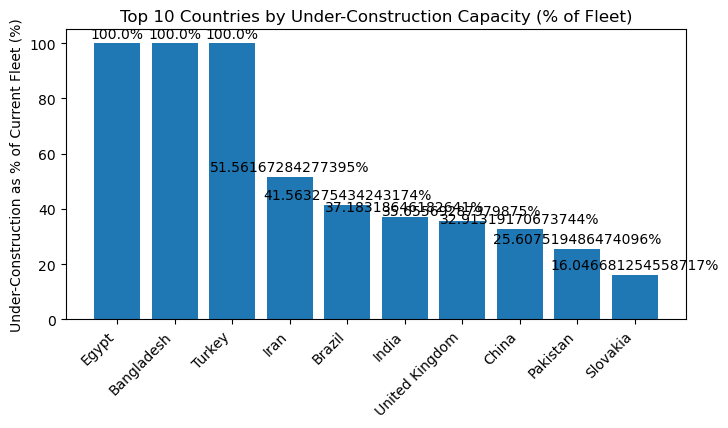

In [22]:
import matplotlib.pyplot as plt
# If you’re in a notebook make sure you have inline plots:
%matplotlib inline

# Prepare data
countries = top10["Country"].tolist()
values    = top10["PipelinePct"].tolist()

# Create the figure
fig, ax = plt.subplots(figsize=(8, 5))

# Draw bars
ax.bar(range(len(countries)), values)

# Set ticks *and* labels together
ax.set_xticks(range(len(countries)))
ax.set_xticklabels(countries, rotation=45, ha="right")

# Formatting
ax.set_ylabel("Under-Construction as % of Current Fleet (%)")
ax.set_title("Top 10 Countries by Under-Construction Capacity (% of Fleet)")

# Annotate bars
ymax = max(values)
for i, v in enumerate(values):
    ax.text(i, v + ymax*0.02, f"{v}%", ha="center")

# Give a bit more room at the bottom
fig.subplots_adjust(bottom=0.3)

# Show the plot
plt.show()